In [1]:
import numpy as np
import jax.numpy as jnp
import jax
from jax.example_libraries import optimizers
from jax import grad,jit,vmap,jacfwd,jacrev,value_and_grad
from functools import partial
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import time
import os
import jax.scipy as jsp
from jax.scipy.stats import norm
from obj_loader import *
from classes import *
from losses import mse_loss

%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [164]:
viewport = np.array([128,128])
h,w = viewport
col, row = np.meshgrid(np.linspace(-1,1,h),np.linspace(-1,1,w))
points = jnp.stack((col,row), axis=2).reshape(h,w,2) 

camera = Camera(get_points_from_angles(0,90,2.7),jnp.array([0.,1.,0.]),jnp.array([0.,0.,0]))

light = Light(get_points_from_angles(0,90,2.3),2)

triangle = load_obj('obj/triangle.obj',normalization=False)
mesh_triangle_ref = triangle[0][triangle[1].astype(int)]
mesh_triangle_ref = jnp.concatenate([mesh_triangle_ref,jnp.ones([mesh_triangle_ref.shape[0],3,1])],axis=-1)
normals_triangle = triangle[3][triangle[1]]
normals_triangle = normalize(normals_triangle,-1)

material_triangle = Material(jnp.array([[0.3,0.2,0.2],[0.7,0.5,0.5],[0.9,0.9,0.9]]),100.)

theta = 15
rotate = jnp.array([[jnp.cos(theta),-jnp.sin(theta),0,0],[jnp.sin(theta),jnp.cos(theta),0,0],[0,0,1,0],[0,0,0,1]])
mesh_triangle = mesh_triangle_ref@rotate

obj1 = Object(mesh_triangle,normals_triangle)
objects = [obj1,]
obj2 = Object(mesh_triangle_ref,normals_triangle)
objects_ref = [obj2,]
materials = [material_triangle,]


In [165]:
blurriness = -3.0
shading_mode = 'phong'
kernel = 'gaussian'
img_init = forward(points,objects,materials,light,camera,shading_mode,kernel,blurriness,False)
img_ref = forward(points,objects_ref,materials,light,camera,shading_mode,'hard',blurriness,False)

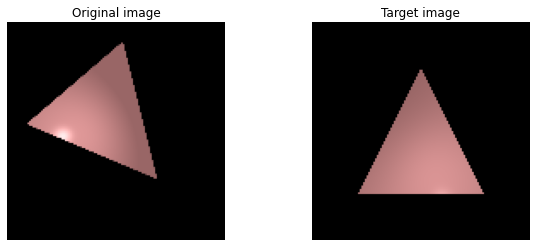

In [166]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Original image')
plt.axis('off')
plt.imshow(img_init,origin='lower',cmap='gray')
plt.subplot(1,2,2)
plt.title('Target image')
plt.axis('off')
plt.imshow(img_ref,origin='lower',cmap='gray')

In [46]:
g,_ = grad(mse_loss,argnums=(1),has_aux=True)(points,objects,materials,light,camera,img_ref,shading_mode,kernel,blurriness,False)
print(g[0].mesh.max())

3806.0166


# single learn

In [48]:
def training(points,objects,materials,light,camera,img_ref,shading_mode,kernel,blurriness,iteration):
    history = []
    history_para = []
    history_img = []

    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8
    lr = 0.1

    m = jnp.zeros_like(objects[0].mesh)
    v = jnp.zeros_like(objects[0].mesh)
    for i in trange(iteration):
        (loss,img),g = value_and_grad(mse_loss,argnums=(1),has_aux=True)(points,objects,materials,light,camera,img_ref,shading_mode,kernel,blurriness,False)
        assert (g[0].mesh == g[0].mesh).any(), 'gradient is nan'
        history.append(loss)
        history_img.append(img)

        m = beta1*m + (1-beta1)*g[0].mesh
        v = beta2*v + (1-beta2)*jnp.square(g[0].mesh)
        m_hat = m/(1-jnp.asarray(beta1,m.dtype)**(i+1))
        v_hat = v/(1-jnp.asarray(beta2,m.dtype)**(i+1))
        objects[0].mesh -= lr*m_hat/(jnp.sqrt(v_hat)+eps)
        
    return history,history_para,history_img

In [167]:
start = time.time()
history,history_para,history_img = training(points,objects,materials,light,camera,img_ref,'phong','gaussian',blurriness,70)
end = time.time()
time_cost = end - start

  0%|          | 0/70 [00:00<?, ?it/s]

Text(0, 0.5, 'Sum of the difference between two images')

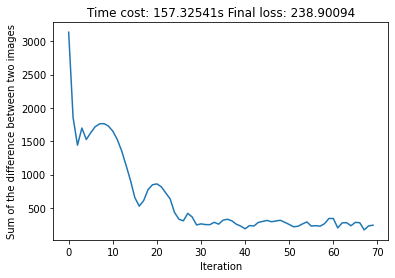

In [168]:
plt.plot(history)
plt.title('Time cost: %.5fs Final loss: %.5f' % (time_cost,history[-1]))
plt.xlabel('Iteration')
plt.ylabel('Sum of the difference between two images')

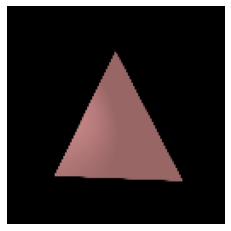

In [169]:
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML
fig = plt.figure()
plt.axis('off')
im = plt.imshow(history_img[0], animated=True, origin='lower',cmap='gray')
def update_fig(i):
    im.set_array(history_img[i])
    return im,
anim = animation.FuncAnimation(fig, update_fig, frames=len(history_img), interval=50, blit=True)
from IPython.display import HTML
HTML(anim.to_jshtml())

In [170]:
anim.save("gif/optimize_vertices_triangle2.gif")